# Network Analysis of Global Air Transportation


---


**Mentor:**
  - ***Professor Chrysafis Vogiatzis***, Department of Industrial and Systems Engineering, University of Illinois at Urbana-Champaign (UIUC).

**Group Members:**
  - ***Dhruv Borda*** (linkedin.com/thebordadhruv)
  - ***Deeksha Manohar Rao*** (linkedin.com/in/deeksha-manohar-rao-6b5108171)
  - ***Sayantan Malladeb*** (linkedin.com/in/sayantan-malladeb)
  - ***Suvrata Gayathri Kappagantula*** (linkedin.com/in/gayathrikappagantula)


---


This project, undertaken for IE532: Analysis of Network Data, delves into the intricacies of the air transportation network. Guided by Professor Chrysafis Vogiatzis at the University of Illinois Urbana-Champaign, our team seeks to unravel the complexities of global air travel networks.

**Goal Statement**
The project aims to analyze and interpret the patterns and efficiencies within the air transportation network, focusing on airline operations, flight routes, and network connectivity.

**Description of Dataset**
We utilized a comprehensive dataset encompassing details about airlines, airports, and flight routes. Despite its extensive coverage, the dataset had limitations in terms of temporal range and granularity, which were addressed during preprocessing.

**Methodology and Computational Implementation**

> **Data Preprocessing**
Our preprocessing involved standardizing and cleaning data, ensuring compatibility and accuracy. We processed data related to airlines, airports, and flight routes, focusing on relevant attributes while discarding extraneous information.

> **Data Inspection**
Through meticulous inspection, we assessed the data's structure and integrity, identifying unique values and preparing it for in-depth analysis.


> **Data Visualization**
We employed network visualizations to illustrate the global flight routes. This graphical representation highlighted the network's structure, emphasizing connections and hubs in the air travel network.

> **Data Analytics**
>
>> **Network Analysis**
>>
>> The network analysis aimed to understand the connectivity and efficiency of the air transportation network. We employed graph-theoretic techniques to analyze network structure, centrality measures, and connectivity patterns.
>
>> **Airline Comparison**
>>
>> In our comparison of airlines, we evaluated performance based on operational factors like number of routes, network spread, and efficiency. This comparative analysis provided insights into the competitive landscape of the airline industry.


**Conclusion**

Our analysis revealed key patterns in air network connectivity, airline operations, and the global distribution of flight routes. We identified central hubs and noted the impact of airline network strategies on overall network efficiency.

The project contributed valuable insights into the functioning of the global air transportation network. It highlighted the importance of strategic route planning and efficient network design in the airline industry. Future work could explore temporal dynamics and the impact of external factors like economic shifts and regulatory changes.



In [2]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import operator

# Data Preprocessing

In [2]:
def RoutesDataLoading(file):

    routes = pd.read_csv(file, sep=',')

    routes.rename(columns= {"airline":"airline IATA code"}, inplace=True)
    routes.rename(columns= {" source airport":"source airport"}, inplace=True)
    routes.rename(columns= {" source airport id":"source airport ID"}, inplace=True)
    routes.rename(columns= {" destination apirport":"destination airport"}, inplace=True)
    routes.rename(columns= {" destination airport id":"destination airport ID"}, inplace=True)
    routes.rename(columns= {" codeshare":"codshare"}, inplace=True)
    routes.rename(columns= {" stops":"stops"}, inplace=True)
    routes.rename(columns= {" equipment":"equipment"}, inplace=True)

    # delete unnecessary columns
    routes = routes.reindex(columns=["airline IATA code", "airline ID", "source airport", "source airport ID", "destination airport", "destination airport ID"])

    # delete rows with unknown source or destination airports ID's
    routes = routes[(routes["source airport ID"]!="\\N") & (routes["destination airport ID"]!="\\N")]

    # delete rows with unknown airline IDs
    routes = routes[routes["airline ID"]!="\\N"]

    # change source airport ID column to type integer
    routes["source airport ID"] = routes["source airport ID"].astype(int)

    # change source airport ID column to type integer
    routes["destination airport ID"] = routes["destination airport ID"].astype(int)

    # change airline ID column to type integer
    routes["airline ID"] = routes["airline ID"].astype(int)

    # return dataframe to calling code
    return routes

def AirportsDataLoading(file):

    airports = pd.read_csv(file, sep=',', header=None)
    header = ["source airport ID", "airport name", "airport city", "airport country", "IATA", "ICAO", "latitude", "longitude", "altitude", "timezone", "DST", "Tz Olson format", "type", "source"]
    airports.columns = header

    # delete unnecessary columns
    airports = airports.reindex(columns=["source airport ID", "airport name", "airport city", "airport country", "latitude", "longitude"])

    # return dataframe to calling code
    return airports

def AirlinesDataLoading(file):

    airlines = pd.read_csv(file, sep=',', header=None)
    header = ["airline ID", "name airline", "alias", "IATA", "ICAO", "callsign", "country airline", "active"]
    airlines.columns = header

    # delete unnecessary columns
    airlines = airlines.reindex(columns=["airline ID", "name airline", "country airline"])

    return airlines

def DataMerging(LeftData, RightData, on):

    MergedData = pd.merge(LeftData, RightData, on=on, how = "left")

    return MergedData

def DataCleaning(df):

    while True:

        RemoveAirports = []

        # create a list of source airports to compare the destination airports
        AirportsSourceID = df["source airport ID"].tolist()

        for ID in df["destination airport ID"]:
            if ID not in AirportsSourceID:
                RemoveAirports += [ID]

        if RemoveAirports == []:

            return df
            break

        else:

            df = df[~df["destination airport ID"].isin(RemoveAirports)]

# Data Inspection

In [3]:
def ColumnInspection(specific_df):
    print('\nVariables in the dataframe: \n')
    print(specific_df.columns.tolist())

def ValueInspection(specific_df):
    print('\nUnique values per variable \n')
    for column in specific_df.columns:
        print(f'{column} = {len(specific_df[column].unique())}')

def FlightsAirportsInspection(df):
    test = df['source airport'].value_counts()[:10].reset_index()
    test.plot.bar(x = "index", y = "source airport", legend=False)
    plt.ylabel("flight routes")
    plt.show()

def DataBarplot(table, x, y, ylabel = None):
    table.plot.bar(x, y, legend=False)
    plt.ylabel(ylabel)
    plt.show()

def DataInspection(routes, airports, merged):

    extra_options = input("""What would you want to do?
    1\tShow in which countries most airports are located
    2\tShow 10 biggest airports based on number of incoming flights
    3\tShow 10 biggest airports based on degree (most connected)
    4\tShow 10 biggest airlines
    Enter Your Response (1/2/3/4): """)

    if extra_options == '1':
        print('\nThe 10 countries with most airports: \n')
        merged['airport country'].value_counts()[0:10].plot.pie()
        plt.show()

    elif extra_options == '2':
        print('\nThe 10 biggest airports based on number of incoming flights: \n')
        FlightsAirportsInspection(merged)

    elif extra_options == '3':
        print('\nThe 10 biggest airports based on degree (most connected): \n')
        hub_table = FindAirports(merged, 10)
        DataBarplot(hub_table, x="airport" , y="degree", ylabel="flight routes")

    elif extra_options == '4':
        print('\nThe 10 biggest airlines: \n')
        df_table_airlines = TableAirlinesName(merged)[:10]
        DataBarplot(df_table_airlines, x="name airline" , y="flight_routes_nr" , ylabel="flight routes")
    else:
        print('\nSorry, this is not an option, we will return to the main program')


def CreateGraph2(df):
    graph = nx.from_pandas_edgelist(df, source = 'source airport', \
                                 target = 'destination airport')
    return graph


# function to determine the degree of each node in a graph object
def NodeDegree2(graph):

    # calculate degree of each node and save as dictionary
    degree = dict(graph.degree())

    # sort nodes by degree
    # (since dictionaries can not be sorted on value we use the itemgetter function)
    degree_sorted = sorted(degree.items(), key = operator.itemgetter(1), reverse=True)

    # create dataframe with nodes (airports) and degree per node
    degree_nodes = pd.DataFrame(degree_sorted, columns=["airport", "degree"])

    return degree_nodes


def FindAirports(df, hubs_nr):

    # make graph object from dataframe
    graph = CreateGraph2(df)

    # caluculate degree of each nodes (degree is the amount of edges a node has)
    degree_nodes = NodeDegree2(graph)

    # select the top degree nodes (hubs) based on the specified number of hubs
    hub_table = degree_nodes[:hubs_nr]

    return hub_table

def CreateAirportsNetwork(df, hub_table):

    # create a list of hubs from the table
    hublist = hub_table["airport"].tolist()

    # select all flights from hub airports from the df
    hub_df_source = df[df["source airport"].isin(hublist)]

    # select all flights to hub airports from the df
    hub_df_dest = df[df["destination airport"].isin(hublist)]

    # concatenate these two selections to create a df with all in and outcoming flights from hub airports
    df_hubnetwork = pd.concat([hub_df_source, hub_df_dest], axis=0)

    # clean hub network dataframe
    df_hubnetwork_clean = DataCleaning(df_hubnetwork)

    return df_hubnetwork_clean


# create a dataframe with only the in and outcoming flights from a specific airport
def SpecificAirport(df, airport):

    hub_df_source = df[df["source airport"]==airport]
    hub_df_dest = df[df["destination airport"]==airport]
    df_specific_airport = pd.concat([hub_df_source, hub_df_dest], axis=0)
    df_specific_airport_clean = DataCleaning(df_specific_airport)

    return df_specific_airport_clean


def TableAirlines(dataframe):

    # ordering the airlines by number of flights
    df_top_airlines = dataframe['airline IATA code'].value_counts().reset_index()

    # rename columns
    df_top_airlines.rename(columns= {'airline IATA code':'flight_routes_nr'}, inplace=True)
    df_top_airlines.rename(columns= {'index':'airline IATA code'}, inplace=True)

    return df_top_airlines

#function to create a dataframe in which airlines are ordered by flights number and their complete name is displayed
def TableAirlinesName(dataframe):

    # ordering the airlines by number of flights
    df_top_airlines = dataframe['name airline'].value_counts().reset_index()

    # rename columns
    df_top_airlines.rename(columns= {'name airline':'flight_routes_nr'}, inplace=True)
    df_top_airlines.rename(columns= {'index':'name airline'}, inplace=True)

    return df_top_airlines

#function to create a dataframe with the selected airline only
def SelectAirlines(dataframe, sel_airline):

    # select only the rows of dataframe where airline is the same as the selected airline
    dataframe = dataframe[dataframe['airline IATA code'] == (sel_airline)]

    # clean dataframe
    dataframe_clean = DataCleaning(dataframe)

    return dataframe_clean


#function to create a dataframe with the n. of seleced airlines only
def SelectNAirlines(dataframe, TableAirlines, number):

    # take only the first # airlines (amount selected by the user)
    df_airlines = TableAirlines[:number]

    # make the previous variable into a list
    airl_list = df_airlines['airline IATA code'].tolist()

    # create a dataframe of flight only by those airlines
    dataframe = dataframe.loc[dataframe['airline IATA code'].isin(airl_list)]

    # clean dataframe
    dataframe_clean = DataCleaning(dataframe)

    return dataframe_clean


#%% Functions to define user input for specific airports and airlines

def UserDefinedAirline(df):

    # create a list of unique airlines
    unique_airlines_list = df["airline IATA code"].drop_duplicates().tolist()

    # initialise input to false
    input_airline = False

    # ask user for an airline to visualise on the map until a valid input is given
    while input_airline == False:

        airline = input("""
        Which airline do you want to visualise? Enter the 2-letter IATA code in
        capital letters.

        For inspiration see the 10 airlines with the most flight routes:

        FR\tRyanair
        AA\tAmerican Airlines
        UA\tUnited Airlines
        DL\tDelta Air Lines
        US\tUS Airways
        CZ\tChina Southern Airlines
        MU\tChina Eastern Airlines
        CA\tAir China
        WN\tSouthwest Airlines
        U2\teasyJet

        Enter your answer here: """)

        # if input is in the list with unique airlines, proceed
        if airline in unique_airlines_list:

            # create a dataframe with only the fligths of the specified airline
            df_airline = SelectAirlines(df, airline)

            input_airline == True

            return df_airline

        # if an invalid input is given, give message accordingly and let user try again
        else:
            print("This is not a valid input, try again")

def UserDefinedAirport(df):

    # create a list of unique airlines
    unique_airport_list = df["source airport"].drop_duplicates().tolist()

    # initialise input to false
    input_airport = False

    # ask user for an airline to visualise on the map until a valid input is given
    while input_airport == False:

        airport = input("""
        Which airport do you want to visualise? Enter the 3-letter IATA code in
        capital letters.

        For inspiration see the 10 airports with the most flight routes:

        AMS\tAmsterdam Airport Schiphol
        FRA\tFrankfurt am Main International Airport
        CDG\tCharles de Gaulle International Airport
        IST\tAtatürk International Airport
        ATL\tHartsfield Jackson Atlanta International Airport
        PEK\tBeijing Capital International Airport
        ORD\tChicago O'Hare International Airport
        MUC\tMunich International Airport
        DME\tDomodedovo International Airport
        DFW\tDallas Fort Worth International Airport

        Enter your answer here: """)

        # if input is in the list with unique airlines, proceed
        if airport in unique_airport_list:

            # create a dataframe with only the fligths of the specified airline
            df_airport = SpecificAirport(df, airport)

            input_airport == True

            return df_airport

        # if an invalid input is given, give message accordingly and let user try again
        else:
            print("This is not a valid input, try again")

# Data Visualization

In [4]:
def CreateGraph(df, directionality):
    graph = nx.from_pandas_edgelist(df, source = 'source airport', \
                                 target = 'destination airport', create_using = directionality)
    return graph


# function to create variable pos, that contains the position of each node
def CreatePOS(df, m):

    mx, my = m(df['longitude'].values, df['latitude'].values)
    pos = {}
    for count, elem in enumerate (df['source airport']):
         pos[elem] = (mx[count], my[count])

    return pos

def NodesAndEdges(graph, pos, node_size, node_visibility, edge_visibility, ncolor='#F7A538', ecolor='#5EC4B7', ewidth = 2):

    nx.draw_networkx_nodes(graph, pos, node_size = node_size, node_color = ncolor, alpha = node_visibility)
    nx.draw_networkx_edges(graph, pos, edge_color = ecolor, width = ewidth, alpha = edge_visibility)

def NodeDegree(graph):

    degree = dict(graph.degree())

    node_size_list = []
    for h in degree.values():
        node_size_list = node_size_list + [h * 1.5]

    return node_size_list

def BiggestAirports(df, hub_nr, graph_df, pos, color):

    hub_table = FindAirports(df, hub_nr)

    hublist = hub_table["airport"].tolist()
    node_size = hub_table["degree"].tolist()

    nx.draw_networkx_nodes(graph_df, pos, nodelist=hublist, node_color=color, node_size = node_size)

def AirportLabels(hub_table, graph, pos):

    hublist = hub_table["airport"].tolist()
    labels = {}

    for hub in hublist:
        labels[hub] = hub

    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=12, font_color='#000000')

def CreateWorldmap(dataframe, directionality=nx.Graph(), node_size=20, hub_nr=0, node_visibility=0.8, edge_visibility=0.1):

    graph = CreateGraph(dataframe, directionality)

    graph_info = nx.info(graph)
    print(graph_info)

    plt.figure(figsize = (15,20))
    m = Basemap(projection='merc',
                llcrnrlon=-180,
                llcrnrlat=-80,
                urcrnrlon=180,
                urcrnrlat=80)

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,60))

    pos = CreatePOS(dataframe, m)
    NodesAndEdges(graph, pos, node_size, node_visibility, edge_visibility)

    if hub_nr > 0:
        BiggestAirports(dataframe, hub_nr, graph, pos, '#CC0000')

        # find biggest hubs and draw hub labels
        hub_table = FindAirports(dataframe, hub_nr)
        AirportLabels(hub_table, graph, pos)

    # show plot
    plt.show()

def DataVisualization(dataframe):
    CreateWorldmap(dataframe)

def DataVisualizationUserDefined(dataframe):

    dataframe = dataframe
    directionality = nx.Graph()
    node_size = 20
    hub_nr = 0

    # 1st parameter: amount of airlines and airports
    map_amount = input("""What do you want to do?
    1\tSelect all airlines and airports
    2\tSelect specific airlines
    3\tSelect specific airports
    Enter Your Response (1/2/3): """)

    if map_amount == '1':
        print('You chose to plot all airlines and airports')
        # dataframe input parameter for metafunction is default

    elif map_amount == '2':
        print('You chose to plot specific airlines')
        choice_airlines = input("""What do you want to do?
        1\tSelect the biggest airlines
        2\tSelect a specific airline
        Enter Your Response (1/2): """)

        if choice_airlines == '1':
            print('You chose to plot the biggest airlines')
            map_number_airlines = int(input('How many of the biggest airlines do you want to plot? (1 to 15) '))

            if 1 <= map_number_airlines <= 15:
                print(f'You chose to plot the top {map_number_airlines} biggest airlines')

                # create a table with the top airlines with n. of flights (with IATA code)
                Table_Airlines = TableAirlines(dataframe)

                # create a table with the top airlines with n. of flights (full airline names)
                TableAirlines_Name = TableAirlinesName(dataframe)

                # create input parameter for metafunction: dataframe with only the flights of the desired n. of airlines
                dataframe = SelectNAirlines(dataframe, Table_Airlines, map_number_airlines)

                # show barplot of number of flight routes per airline, by first taking top n rows of airline table
                top_table = TableAirlines_Name[:map_number_airlines]
                DataBarplot(top_table, x="name airline" , y="flight_routes_nr" , ylabel="flight routes")


            else:
                print('\nSorry, this is not an option, we will use the default setting: all airports and airlines')


        elif choice_airlines == '2':
            print('You chose to plot a specific airline based on name')

            # create input parameter for metafunction: dataframe with only the in- and outcoming flights of the selected airport through user
            dataframe = UserDefinedAirline(dataframe)

        else:
            print('\nSorry, this is not an option, we will use the default setting: all airports and airlines')


    elif map_amount == '3':
        print('You chose to plot specific airports')
        choice_airports = input("""What do you want to do?
        1\tSelect the biggest airports
        2\tSelect a specific airports
        Enter Your Response (1/2): """)

        if choice_airports == '1':
            print('You chose to plot the biggest airports')
            map_number_airports = int(input('How many of the biggest airports do you want to plot? (1 to 15) '))
            if 1 <= map_number_airports <= 15:

                hub_nr = map_number_airports
                print(f'You chose to plot the top {hub_nr} biggest airports')

                # determine what are the top 'n' most connected airports (hubs)
                hub_table = FindAirports(dataframe, hub_nr)

                # create input parameter for metafunction: dataframe with only the in- and outcoming flights from hub airports
                dataframe = CreateAirportsNetwork(dataframe, hub_table)

                # show barplot of amount of flight routes (edges) per hub airport
                DataBarplot(hub_table, x="airport" , y="degree", ylabel="flight routes")
            else:
                print('\nSorry, this is not an option, we will use the default setting: all airports and airlines')

        elif choice_airports == '2':
            print('You chose to plot a specific airport based on name')

            # create input parameter for metafunction: number of hubs to visualise
            hub_nr = 1

            # create input parameter for metafunction: dataframe with only the in- and outcoming flights of the selected airport through user
            dataframe = UserDefinedAirport(dataframe)

    else:
        print('\nSorry, this is not an option, we will use the default setting: all airports and airlines')



    # 2nd parameter: directed or undirected network
    map_edges = input("""What do you want to do?
    1\tMake an undirected network
    2\tMake a directed network
    Enter Your Response (1/2): """)

    if map_edges == '1':
        print(f'You chose to create an undirected network')
        # directionality input parameter for metafunction is default (undirected)

    elif map_edges == '2':
        print(f'You chose to create a directed network')

        # create input parameter for metafunction: directed graph
        directionality = nx.DiGraph()

    else:
        print('\nSorry, this is not an option, we will use the default setting: an undirected network')


    # 3rd parameter: size of the airports
    size_airport = input("""What do you want to do?
    1\tDisplay all airports with the same size
    2\tDisplay size of airport depending on how many flight routes it has (degree)
    Enter Your Response (1/2): """)

    if size_airport == '1':
        print('You chose to display all airports with the same size')
        # node size parameter for metafunction is default (node_size = 20)

    elif size_airport == '2':
        print('You chose to display airport size dependent on degree')

        # create graph object from dataframe defined as first parameter
        graph = CreateGraph(dataframe, nx.Graph())

        # create input parameter for metafunction: use graph object to calculate degree per node and write to list
        node_size = NodeDegree(graph)

    else:
        print('\nSorry, this is not an option, we will use the default setting: all same size ')


    # CALLING METAFUNCTION: VISUALIZE FLIGHT NETWORK WITH USER OPTIONS
    CreateWorldmap(dataframe, directionality, node_size, hub_nr)

# Data Analytics

## Network Analysis

In [5]:
def NetworkAnalysis(df):
    G = nx.from_pandas_edgelist(df, 'source airport', 'destination airport',
                                create_using=nx.DiGraph())
    # Strongly Connected Network
    scc_subs = (G.subgraph(c) for c in nx.strongly_connected_components(G))
    G_sc = max(scc_subs, key=len)

    # Weakly Connected Network
    wcc_subs = (G.subgraph(c) for c in nx.weakly_connected_components(G))
    G_wc = max(wcc_subs, key=len)

    analysis_options = input("""What do you want to do?
    1\tDoes a route exist between every two airport?\n\t Is every airport reachable from every other airport?
    2\tHow many nodes are in the largest weakly connected component?
    3\tHow many nodes are in the largest strongly connected component?
    4\tAverage shortest path length
    5\tDensity of Network
    6\tDegree of Network
    7\tTransitivity and Average Clustering Coefficient
    8\tIndegree and Outdegree
    9\tCentrality Metrics: Closeness and Betweenness
    Enter Your Response (1/2/3/4/5/6/7/8/9): """)

    if analysis_options == '1':
        print('Does a route exist between every two airport?', nx.is_strongly_connected(G))
        print('Is every airport reachable from every other airport?',
          nx.is_connected(G.to_undirected()))

    elif analysis_options == '2':
        wccs = nx.weakly_connected_components(G)
        x = len(max(wccs, key=len))
        print('\nThe percentage of nodes which are weakly connected : \n',
              x/len(G.nodes()))

    elif analysis_options == '3':
        sccs = nx.strongly_connected_components(G)
        x = len(max(sccs, key=len))
        print('\nThe percentage of nodes which are strongly connected : \n',
              x/len(G.nodes()))

    elif analysis_options == '4':
        shortest_sc=nx.average_shortest_path_length(G_sc)
        print('\nThe average shortest path length for largest strongly connected network : \n', shortest_sc)

        shortest_wc=nx.average_shortest_path_length(G_wc)
        print('\nThe average shortest path length for largest weakly connected network : \n', shortest_wc)

    elif analysis_options == '5':
        print('\nThe density of original network: \n', nx.density(G))
        print('\nThe density of largest strongly connected network : \n', nx.density(G_sc))

    elif analysis_options == '6':
        degrees = dict(G.degree())
        degree_values = sorted(set(degrees.values()))
        histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G_sc)) for i in degree_values]
        plt.plot(histogram)

    elif analysis_options == '7':
        print('\nThe transitivity for largest strongly connected network : \n', nx.transitivity(G_sc))
        print('\nThe transitivity for largest weakly connected network : \n', nx.transitivity(G_wc))

        print('\nThe average clustering coefficient for largest strongly connected network : \n', nx.average_clustering(G_sc))
        print('\nThe average clustering coefficient for largest weakly connected network : \n', nx.average_clustering(G_wc))

    elif analysis_options == '8':
        # Indegree
        in_deg=nx.in_degree_centrality(G_sc)
        top5=sorted(in_deg.items(), key=operator.itemgetter(1), reverse=True)[:5]
        t=[]
        for i,j in top5:
            t.append(i)
        bot5=sorted(in_deg.items(), key=operator.itemgetter(1))[:5]
        b=[]
        for i,j in bot5:
            b.append(i)
        print('The top 5 airports with most incoming flights :', t)
        print('The bottom 5 airports with most incoming flights :', b)

        # Outdegree
        out_deg=nx.out_degree_centrality(G_sc)
        top5=sorted(out_deg.items(), key=operator.itemgetter(1), reverse=True)[:5]
        t1=[]
        for i,j in top5:
            t1.append(i)
        bot5=sorted(out_deg.items(), key=operator.itemgetter(1))[:5]
        b1=[]
        for i,j in bot5:
            b1.append(i)
        print('The top 5 airports with most outgoing flights :', t1)
        print('The bottom 5 airports with most outgoing flights :', b1)

    elif analysis_options == '9':
        # Closness Centrality
        print('Closeness Centrality')
        closeness = nx.closeness_centrality(G_sc, wf_improved=True)
        close = sorted(closeness.items(), key=operator.itemgetter(1),reverse=True)[:5]
        c=[]
        for i,j in close:
            c.append(i)

        close=sorted(closeness.items(), key=operator.itemgetter(1))[:5]
        c1=[]
        for i,j in close:
            c1.append(i)
        print('Airports allowing to reach all other airports with the lowest average number of airports in between :', c)
        print('Airports allowing to reach all other airports with the highest average number of airports in between :', c1)

        # Betweenness Centrality
        print('Betweenness Centrality')

        betweeness = nx.betweenness_centrality(G_sc, normalized=True)
        close=sorted(betweeness.items(), key=operator.itemgetter(1),reverse=True)[:5]
        bet=[]
        for i,j in close:
            bet.append(i)
        close=sorted(betweeness.items(), key=operator.itemgetter(1))[:5]
        bet1=[]
        for i,j in close:
            bet1.append(i)
        print('Airports that frequently serve as connectors between groups of airports :', bet)
        print('Airports that rarely serve as connectors between groups of airports :', bet1)
    else:
        print('\nSorry, this is not an option, we will return to the main program')

## Airline Comparison

In [6]:
def NetworkMetrics(df):

    # create graph object of airline network
    graph_airline = CreateGraph2(df)

    # number of nodes and edges
    nnodes = graph_airline.number_of_nodes()
    nedges = graph_airline.number_of_edges()

    # calculate density of the network
    density_airline = nx.density(graph_airline)

    # calculate average shortest path
    short_path_av_airline = nx.average_shortest_path_length(graph_airline)
    global_efficiency_airline = 1/short_path_av_airline

    # define biggest hub
    hub_table_airline = FindAirports(df, 1)
    hub_airline = hub_table_airline.iloc[0,0]

    # create list of graph metrics
    graph_metrics = [nnodes, nedges, density_airline, global_efficiency_airline, hub_airline]

    return graph_metrics


def TableNetworkMetrics(df1, df2):

    # create graph metrics table
    list_graph_metrics_airline1 = NetworkMetrics(df1)
    list_graph_metrics_airline2 = NetworkMetrics(df2)

    # make dataframe of graph metrics
    graph_metrics = pd.DataFrame({"metrics":["nr of nodes", "nr of edges", "density", "global efficiency", "biggest hub"], "airline 1": list_graph_metrics_airline1, "airline 2":list_graph_metrics_airline2})
    print(graph_metrics)


def DoubleNetworkVisualization(df1, df2):

    # create graph object from dataframe for both airlines
    graph_df1 = CreateGraph(df1, nx.Graph())

    graph_df2 = CreateGraph(df2, nx.Graph())

    # draw mercator projection as background and set size
    plt.figure(figsize = (15,20))
    m = Basemap(projection='merc',
                llcrnrlon=-180,
                llcrnrlat=-80,
                urcrnrlon=180,
                urcrnrlat=80)

    # include coastlines, countries and boundaries
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # include longitude and latitude lines if you want
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,60))


    # create variable pos for both airlines, that contains the position of each node
    pos1 = CreatePOS(df1, m)
    pos2 = CreatePOS(df2, m)

    # calculate node size of both airline networks
    node_size1 = NodeDegree(graph_df1)
    node_size2 = NodeDegree(graph_df2)

    # draw the nodes and edges of the airlines on the map and set other parameters for layout
    NodesAndEdges(graph_df1, pos1, node_size1, node_visibility = 0.8, edge_visibility = 0.5, ncolor = "#FF6347", ecolor = '#FFBABA')
    NodesAndEdges(graph_df2, pos2, node_size2, node_visibility = 0.8, edge_visibility = 0.5, ncolor = '#20B2AA', ecolor = '#AFEEEE')

    # draw biggest hubs of airlines
    BiggestAirports(df1, 1, graph_df1, pos1, '#CC0000')
    BiggestAirports(df2, 1, graph_df2, pos2, '#0000CC')

    # find biggest hub of airline and draw labels on the graph
    hub1 = FindAirports(df1, 1)
    AirportLabels(hub1, graph_df1, pos1)

    hub2 = FindAirports(df2, 1)
    AirportLabels(hub2, graph_df2, pos2)

    # show plot
    plt.show()


def AirlinesComparison(df):

    print("\nYou chose to compare airlines.")

    # let user specify airlines to visualize and create dataframes for both
    df_airline1 = UserDefinedAirline(df)

    print("\n\tYou choose your first airline. Now select another one to compare!")

    df_airline2 = UserDefinedAirline(df)

    # visualize airline networks on worldmap
    DoubleNetworkVisualization(df_airline1, df_airline2)

    # print network metrics table
    TableNetworkMetrics(df_airline1, df_airline2)

# Main

In [8]:
try:
    routes = RoutesDataLoading("routes.csv")
except Exception as err:
    print("Something went wrong")
    print(err)

try:
    airports = AirportsDataLoading("airports.csv")
except Exception as err:
    print("Something went wrong")
    print(err)

try:
    airlines = AirlinesDataLoading("airlines.csv")
except Exception as err:
    print("Something went wrong")
    print(err)

MergedAirlinesData = DataMerging(routes, airlines, "airline ID")
MergedData = DataMerging(MergedAirlinesData, airports, "source airport ID")
MergedData = MergedData.reindex(columns=["airline IATA code", "airline ID", "name airline",
                                         "country airline", "source airport", "source airport ID",
                                         "destination airport", "destination airport ID", "airport name",
                                         "airport city", "airport country", "latitude", "longitude"])
MergedData = DataCleaning(MergedData)

What do you want to do?
    1	Data Visualization of the flight network.
    2	Data Visualization of the flight network based on User Parameters.              
    3	Biggest airports/airlines/countries.
    4	Network Analysis.    
    5	Airlines Comparison.
    6	Exit program.
    Enter Your Response (1/2/3/4/5/6): 3
What would you want to do?
    1	Show in which countries most airports are located          
    2	Show 10 biggest airports based on number of incoming flights
    3	Show 10 biggest airports based on degree (most connected)
    4	Show 10 biggest airlines
    Enter Your Response (1/2/3/4): 1

The 10 countries with most airports: 



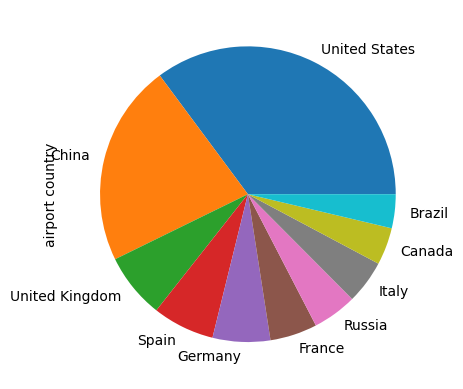

What do you want to do?
    1	Data Visualization of the flight network.
    2	Data Visualization of the flight network based on User Parameters.              
    3	Biggest airports/airlines/countries.
    4	Network Analysis.    
    5	Airlines Comparison.
    6	Exit program.
    Enter Your Response (1/2/3/4/5/6): 4
What do you want to do?
    1	Does a route exist between every two airport?
	 Is every airport reachable from every other airport?
    2	How many nodes are in the largest weakly connected component?              
    3	How many nodes are in the largest strongly connected component?
    4	Average shortest path length
    5	Density of Network
    6	Degree of Network
    7	Transitivity and Average Clustering Coefficient
    8	Indegree and Outdegree
    9	Centrality Metrics: Closeness and Betweenness
    Enter Your Response (1/2/3/4/5/6/7/8/9): 1
Does a route exist between every two airport? False
Is every airport reachable from every other airport? False
What do you want to do

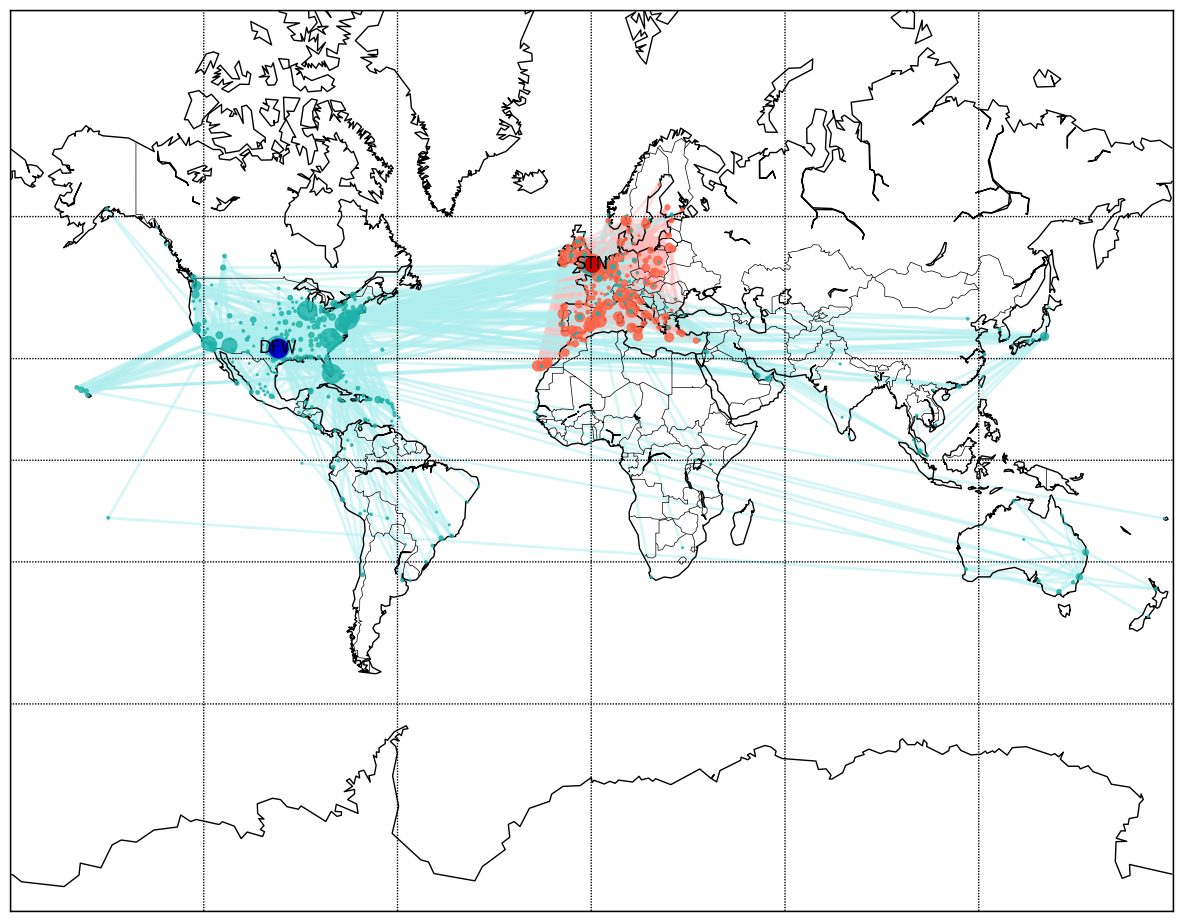

             metrics airline 1 airline 2
0        nr of nodes       176       427
1        nr of edges      1242      1180
2            density  0.080649  0.012974
3  global efficiency  0.460912  0.374175
4        biggest hub       STN       DFW
What do you want to do?
    1	Data Visualization of the flight network.
    2	Data Visualization of the flight network based on User Parameters.              
    3	Biggest airports/airlines/countries.
    4	Network Analysis.    
    5	Airlines Comparison.
    6	Exit program.
    Enter Your Response (1/2/3/4/5/6): 6


In [11]:
while True:
    choice = input("""What do you want to do?
    1\tData Visualization of the flight network.
    2\tData Visualization of the flight network based on User Parameters.
    3\tBiggest airports/airlines/countries.
    4\tNetwork Analysis.
    5\tAirlines Comparison.
    6\tExit program.
    Enter Your Response (1/2/3/4/5/6): """)

    if choice == "1":
        DataVisualization(MergedData)

    elif choice == "2":
        DataVisualizationUserDefined(MergedData)

    elif choice == "3":
        DataInspection(routes, airports, MergedData)

    elif choice == "4":
        NetworkAnalysis(MergedData)

    elif choice == "5":
        AirlinesComparison(MergedData)

    elif choice == "6":
        break

    else:4

        print("Response Invalid")